<a href="https://colab.research.google.com/github/sudimuk2017/AI-for-people-Workshop/blob/master/advanced_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 2 Practical

Today's practical will consist of coding and training a UNET with self attention and comparing the results of training it on a semantic segmentation task side by side with an autoencoder of similar construction. We will explore the effect of different optimizers and learning rates as well as a newer method of creating more accurate models known as exponential moving average models.

For this activity you will definitely need to connect to Google's A100 GPUs, so before you start a kernel, double check that your kernel type is set correctly by clicking on the down-arrow in the top right corner. It should be the one directly to the right of where it says connect or some other kernel description (likely T4 or CPU if you already connected).

## Imports

In [10]:
import random
import time
import gc

import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from torch.utils.data import DataLoader
from torchvision.io import read_image
import copy
nn = torch.nn
F = nn.functional
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# magic!
%matplotlib inline

## Data Prep

This next block will unzip the included data, you only need to run it once, so after the data is unpacked, you will want to comment it out.

The following block is the torch dataset class which will be used to train and test the models as well as to visualize the outputs and ground truth masks.

In [ ]:
!unzip GTAV.zip

In [3]:
!unzip /content/drive-download-20240716T114229Z-001.zip

Archive:  /content/drive-download-20240716T114229Z-001.zip
  inflating: UNET Diagram.png        
  inflating: GTAV.zip                


In [5]:
!unzip GTAV.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTAV/images/02296.png   
  inflating: GTAV/images/01947.png   
  inflating: GTAV/images/00481.png   
  inflating: GTAV/images/01953.png   
  inflating: GTAV/images/00495.png   
  inflating: GTAV/images/02282.png   
  inflating: GTAV/images/00324.png   
  inflating: GTAV/images/01984.png   
  inflating: GTAV/images/00442.png   
  inflating: GTAV/images/02255.png   
  inflating: GTAV/images/02241.png   
  inflating: GTAV/images/01990.png   
  inflating: GTAV/images/00456.png   
  inflating: GTAV/images/01748.png   
  inflating: GTAV/images/00330.png   
  inflating: GTAV/images/01006.png   
  inflating: GTAV/images/00318.png   
  inflating: GTAV/images/02269.png   
  inflating: GTAV/images/01760.png   
  inflating: GTAV/images/01774.png   
  inflating: GTAV/images/01012.png   
  inflating: GTAV/images/00683.png   
  inflating: GTAV/images/02094.png   
  inflating: GTAV/images/02080.png   
  inflating: GTAV/images/00697.png   

In [6]:
!ls

 drive-download-20240716T114229Z-001.zip   GTAV.zip   sample_data
 GTAV					   __MACOSX  'UNET Diagram.png'


In [7]:
cd GTAV

/content/GTAV


In [8]:
ls

images/  labels/  test.txt  train.txt


In [37]:
class GTAVSegmentationDataset(torch.utils.data.Dataset):
    # Constructor
    def __init__(self, train=True):
        # Define the color palette for semantic segmentation
        self.semantic_colours = (torch.tensor([
            [0, 0, 0], [128, 64, 128], [244, 35, 232], [70, 70, 70],
            [102, 102, 156], [190, 153, 153], [153, 153, 153], [250, 170, 30],
            [220, 220, 0], [107, 142, 35], [152, 251, 152], [70, 130, 180],
            [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100],
            [0, 80, 100], [0, 0, 230], [119, 11, 32]
        ]) / 255).tolist()

        # Initialize the list to store file names
        self.file_names = []
        # Determine the dataset split (train/test)
        split = 'train' if train else 'test'
        # Read the file names from the corresponding text file
        with open(f'/content/GTAV/{split}.txt', 'r') as f:
            entry = f.readline()
            while entry:
                self.file_names.append(entry.strip())
                entry = f.readline()

    # Return the number of items in the dataset
    def __len__(self):
        return len(self.file_names)

    # Get a dataset item (image and label) by index
    def __getitem__(self, idx):
        name = self.file_names[idx]
        # Load the image and label, normalize the image
        sample = (read_image(f'/content/GTAV/images/{name}').float() / 255, read_image(f'/content/GTAV/labels/{name}'))
        return sample

    # Convert a segmentation mask to a plottable RGB image
    def get_plottable_mask(self, idx):
        if type(idx) is int:
            mask = read_image(f'/content/GTAV/labels{self.file_names[idx]}').squeeze(0)
        else:
            mask = idx.squeeze(0)
        h, w = mask.shape
        mask = mask.flatten().tolist()
        return torch.tensor([self.semantic_colours[i] for i in mask]).reshape((h, w, 3))

    # Get a plottable RGB image by index
    def get_plottable_image(self, idx):
        return read_image(f'/content/GTAV/images{self.file_names[idx]}').permute(1, 2, 0).float() / 255

    # Plot the original image overlaid with the segmentation mask
    def plot_masked_im(self, idx):
        seg = self.get_plottable_mask(idx)
        im = self.get_plottable_image(idx)
        plt.imshow(im / 3 + seg / 3 * 2)

    # Plot the original image with ground truth and predicted segmentation masks
    def plot_pred_masked_im(self, idx, model):
        x, y = self[idx]
        pred = model.forward(x.to(device=model.device, dtype=torch.float).unsqueeze(0)).argmax(1)
        x_, y_, pred_ = x.permute(1, 2, 0), self.get_plottable_mask(y), self.get_plottable_mask(pred)
        fig = plt.figure(figsize=(5, 6.5))
        ax1 = fig.add_subplot(211)
        ax1.imshow(x_ / 3 + y_ / 3 * 2)
        ax1.set_title('Ground Truth')
        ax2 = fig.add_subplot(212)
        ax2.imshow(x_ / 3 + pred_ / 3 * 2)
        ax2.set_title('Predicted')
        plt.show()

## AutoEncoder

This code is given to you both as reference and for comparison. In Task 2, we will train both an autoencoder and the UNET you write in Task 1 and compare the result of training using skip connections and transformers, which are the only differences between the autoencoder and UNET.

In [38]:
class DoubleConv(nn.Module):
    # Initialize the DoubleConv module
    def __init__(self, in_c, out_c, mid_c=None, residual=False):
        super().__init__()
        self.residual = residual  # Whether to use residual connections
        if not mid_c:
            mid_c = out_c  # If mid_c is not provided, use out_c
        # Define a sequence of operations: two convolutional layers with normalization and activation
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, mid_c, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_c),
            nn.GELU(),
            nn.Conv2d(mid_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_c)
        )

    # Forward pass through the module
    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))  # Apply residual connection if enabled
        else:
            return self.double_conv(x)  # Otherwise, just pass through the double convolution

class Down(nn.Module):
    # Initialize the Down module for downsampling
    def __init__(self, in_c, out_c):
        super().__init__()
        # Define a sequence of operations: max pooling followed by two DoubleConv modules
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c, in_c, residual=True),
            DoubleConv(in_c, out_c)
        )

    # Forward pass through the module
    def forward(self, x):
        x = self.maxpool_conv(x)  # Apply max pooling and convolutions
        return x

class Up(nn.Module):
    # Initialize the Up module for upsampling
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Define a sequence of operations: upsampling followed by two DoubleConv modules
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            DoubleConv(in_channels, in_channels),
            DoubleConv(in_channels, out_channels, in_channels // 2)
        )

    # Forward pass through the module
    def forward(self, x):
        return self.upconv(x)  # Apply upsampling and convolutions

class AutoEncoder(nn.Module):
    # Initialize the AutoEncoder module
    def __init__(self, denoising=False):
        super().__init__()
        channel_list = [64, 128, 256, 512]  # Define the channel sizes
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Determine the device
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            DoubleConv(3, channel_list[0]),
            Down(channel_list[0], channel_list[1]),
            Down(channel_list[1], channel_list[2]),
            Down(channel_list[2], channel_list[3]),
            DoubleConv(channel_list[3], 1), nn.Flatten(), nn.Linear(464, 64)
        )
        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 464), nn.Unflatten(-1, (1, 16, 29)),
            DoubleConv(1, channel_list[3]),
            Up(channel_list[3], channel_list[2]),
            Up(channel_list[2], channel_list[1]),
            Up(channel_list[1], channel_list[0]),
            nn.Sequential(nn.Conv2d(channel_list[0], 20, kernel_size=1), nn.Softmax(1))
        )

    # Forward pass through the autoencoder
    def forward(self, x):
        return self.decoder(self.encoder(x))  # Encode, then decode the input

## Task 1: Code the UNET

The first task will be to create a UNET model by adding skip connections and transformer layers to the autoencoder given before.

The Self-attention layer is given, but you will need to create a new upUNET module which enables the skip connections. This will require little more than a few modifications to the forward pass, namely a new input and a bit of processing to combine the two images correctly. Note for the UNET itself, that the input and the skip input should be the same size.

For the UNET itself, the structure and channel values will be the same as the AutoEncoder, but in order to make skip connections work, we will need to save intermediary feature maps along the downward part of the path to use again in the upward part.

That said, if we don't use as many Sequential layers as possible, torch will have a tough time using the VRAM given for the summer school effectively. This means, use as many nn.Sequential layers as possible while keeping the needed intermediary feature-images for the upward part of the UNET.

Transformers should be included after each Down and UpUNET layer (except the last UpUNET, it has just too many parameters for this GPU setup), to determine the size to input, think about what size the image will be after each submodule. Since the convolutions are padded, you should only need to consider the pooling and upsample portions of each.

We found that calling gc.collect() after the UpUNET/SelfAttention blocks helped keep the RAM load lower by deleting the unneeded intermediaries used for each.

To assist in this process, you can refer to both the provided AutoEncoder and the diagram included in Diagram.pdf.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels, self.size = channels, size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size[0] * self.size[1]).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value * x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size[0], self.size[1])


class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c, mid_c=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_c:
            mid_c = out_c
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, mid_c, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_c),
            nn.GELU(),
            nn.Conv2d(mid_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_c)
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c, in_c, residual=True),
            DoubleConv(in_c, out_c)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class UpUNET(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            DoubleConv(in_c, in_c),
            DoubleConv(in_c, out_c, in_c // 2)
        )

    def forward(self, x, skip_x):
        x = self.upconv[0](x)
        x = torch.cat((x, skip_x), dim=1)
        x = self.upconv[1](x)
        x = self.upconv[2](x)
        return x

class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.encoder_input = DoubleConv(3, 64)
        self.encoder_downsampl1 =nn.Sequential(Down(64, 128), SelfAttention(128, (64, 116)))


In [ ]:
def forward(self, x):
        # Calculate the correct dimensions based on the input shape
        batch_size, sequence_length, channels = x.shape
        x = x.view(batch_size, sequence_length, channels)
        # ... (rest of the forward method remains unchanged)

In [45]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels, self.size = channels, size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size[0] * self.size[1]).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value * x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size[0], self.size[1])


class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c, mid_c=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_c:
            mid_c = out_c
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, mid_c, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_c),
            nn.GELU(),
            nn.Conv2d(mid_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_c)
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c, in_c, residual=True),
            DoubleConv(in_c, out_c)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class UpUNET(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            DoubleConv(in_c, in_c),
            DoubleConv(in_c, out_c, in_c // 2)
        )

    def forward(self, x, skip_x):
        x = self.upconv[0](x)
        x = torch.cat((x, skip_x), dim=1)
        x = self.upconv[1](x)
        x = self.upconv[2](x)
        return x

class UNET(nn.Module):
    """Initialize the UNET model with the given number of input channels and output classes."""
    def _init_(self):
        super()._init_()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Determine the device
        self.encoder_input = DoubleConv(3, 64)  # Define the encoder input
        self.encoder_downsample1 = nn.Sequential(Down(64, 128), SelfAttention (128, (64, 116)))   # Define the encoder downsample
        self.encoder_downsample2 = nn.Sequential(Down(128, 256), SelfAttention (256, (32, 58)))  # Define the encoder downsample
        self.bottleneck = nn.Sequential(Down(256, 256),
                                        SelfAttention (256, (16, 29)),
                                        DoubleConv(256, 512),
                                        DoubleConv(512, 512),
                                        DoubleConv(512, 256)
                            )  # Define the bottleneck
        self.decoder_upsample1 = UpUNET(512, 128)  # Define the decoder upsample
        self.decoder_attention1 = SelfAttention (128, (32, 58))  # Define the decoder attention
        self.decoder_upsample2 = UpUNET(256, 64)  # Define the decoder upsample
        self.decoder_attention2 = SelfAttention (64, (64, 116))  # Define the decoder attention
        self.decoder_upsample3 = UpUNET(128, 64)  # Define the decoder upsample
        self.decoder_output = nn.Sequential(nn.Conv2d(64, 20, kernel_size=1), nn.Softmax(1))  # Define the decoder output

    def forward(self, x):
        """Connect the individual layers of the UNET model to form the complete model."""
        x1 = self.encoder_input(x)  # Encode the input
        x2 = self.encoder_downsample1(x1)  # Encode the first downsample
        x3 = self.encoder_downsample2(x2)  # Encode the second downsample
        x4 = self.bottleneck(x3)  # Encode the bottleneck
        return x

## Task 2: Train Both Models for Segmentation

Task 2 is to attempt to train the most accurate versions of both the AutoEncoder and UNET models. We have provided some alternatives for several of the provided hyperparameters. Try not to spend too much time at first (keep epochs low). There are tradeoffs relative to number of epochs and the chosen optimizer/learning rate, but if you look into each optimizer, it should be possible to determine a best setup.

In testing, we were about to get around 75 and 80% accuracy on the AutoEncoder and UNET, respectively.

One aspect of each model that is interesting to look into is the included EMA model class. What this does can be read about [here](https://leimao.github.io/blog/Exponential-Moving-Average/), but suffice to say, the exponential moving average of the model parameters are learned and can be compared directly with the final model parameters. This removes a lot of the jitteriness from training, though it can sometimes be a bit finicy to get the beta right. If you find this interesting, see if you can use it to make a more accurate model.

The SegmentationTrainer automatically trains both, you can test using the EMA model by passing True to the trainer's test method (and, of course, False if you want to use the regular model, though this is default).

In [46]:
class EMA:
    """
    Implements an Exponential Moving Average (EMA) for model parameters.
    EMA can help in stabilizing and improving model performance over time.
    """
    def __init__(self, beta):
        """
        Initializes the EMA object.

        Parameters:
        - beta (float): The decay rate for the moving average. Determines the weight of historical data.
        """
        self.beta = beta  # Decay rate for the moving average
        self.alpha = 1 - beta  # Complement of beta, used to weight the most recent data
        self.step = 0  # Counter to track the number of steps/updates

    def move_averages(self, ema_model, model):
        """
        Updates the EMA model parameters based on the current model parameters.

        Parameters:
        - ema_model (torch.nn.Module): The model whose parameters are the exponential moving averages.
        - model (torch.nn.Module): The current model from which to calculate the moving averages.
        """
        # Iterate over the parameters of the current model and the EMA model
        for cur_mod, cur_ema in zip(model.parameters(), ema_model.parameters()):
            old_weight, new_weight = cur_ema.data, cur_mod.data  # Extract current and new weights
            # Update the EMA model's parameters
            cur_ema.data = self.move_average(old_weight, new_weight)

    def move_average(self, old, new):
        """
        Calculates the new exponential moving average based on the old average and new value.

        Parameters:
        - old (torch.Tensor): The previous value of the moving average.
        - new (torch.Tensor): The new value to incorporate into the moving average.

        Returns:
        - torch.Tensor: The updated moving average.
        """
        return old * self.beta + new * self.alpha  # Calculate the updated moving average

    def step_ema(self, ema_model, model, start_ema=500):
        """
        Performs a step of EMA update. It either resets the EMA model with the current model's parameters
        if within the start period, or updates the EMA parameters based on the current model's parameters.

        Parameters:
        - ema_model (torch.nn.Module): The EMA model to update.
        - model (torch.nn.Module): The current model from which to update the EMA model.
        - start_ema (int, optional): The number of steps to wait before starting to apply EMA. Defaults to 500.
        """
        if self.step < start_ema:
            # If within the start period, reset the EMA model to the current model's parameters
            self.reset(ema_model, model)
        else:
            # Otherwise, update the EMA model's parameters
            self.move_averages(ema_model, model)
        self.step += 1  # Increment the step counter

    def reset(self, ema_model, model):
        """
        Resets the EMA model's parameters to be identical to the current model's parameters.

        Parameters:
        - ema_model (torch.nn.Module): The EMA model to reset.
        - model (torch.nn.Module): The current model whose parameters will be copied to the EMA model.
        """
        ema_model.load_state_dict(model.state_dict())  # Copy parameters from the current model to the EMA model

This next provided class demonstrates one common way to train and test models. Everything needed to train the model is contained within a single class and training and testing are methods within the class that can be called as needed.

There are countless ways to define training and testing loops for torch models, so this is by no means the defacto or best way, but if you are interested in coding very fast models as lazily as possible, this style of defining a trainer is similar to what is used by [PyTorchLightning](https://lightning.ai/docs/pytorch/stable/) to write models which automatically determine the most optimal device usage and jit declarations to make an unoptimized torch model super fast.

In [47]:
class SegmentationTrainer():
    # Initialize the trainer with model, batch size, optimizer, learning rate, and any additional arguments needed for the optimizer
    def __init__(self, model, batch_size, opt, lr, **kwargs):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Determine the device to use
        self.ce_weights = torch.ones((20)).to(self.device)  # Initialize class weights for cross-entropy
        # Initialize the model and move it to the appropriate device
        self.model = model().to(device=self.device, dtype=torch.float)
        # Create data loaders for training and testing datasets
        self.train_data, self.test_data = DataLoader(GTAVSegmentationDataset(train=True), batch_size, shuffle=True), DataLoader(GTAVSegmentationDataset(train=False), batch_size, shuffle=True)
        # Initialize the optimizer with model parameters and learning rate
        self.opt = opt(self.model.parameters(), lr=lr, **kwargs)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.ema = EMA(beta=.99)

    # Method to train the model
    def train(self, epochs):
        start = time.time()  # Start timing the training process
        loss_history = torch.zeros((5))  # Initialize a tensor to keep track of the last 5 losses
        lh = []  # List to store all loss values for plotting or analysis
        for epoch in range(epochs):  # Loop over the number of epochs
            print('Epoch: ', epoch + 1)
            pbar = tqdm(self.train_data)  # Initialize a progress bar
            for e, (x, y) in enumerate(pbar, 1):  # Loop over the training data
                # Update class weights based on the batch labels
                self.ce_weights += y.flatten().int().bincount(minlength=20).to(self.device)
                # One-hot encode the labels and move them to the correct device
                y = F.one_hot(y.to(dtype=torch.long).squeeze(1), 20).permute(0, 3, 1, 2).to(device=self.device, dtype=torch.float)
                x = x.to(device=self.device, dtype=torch.float)  # Move the inputs to the correct device
                pred = self.model(x)  # Get the model predictions
                loss = F.cross_entropy(pred, y, self.reweight(self.ce_weights))  # Calculate the loss
                self.opt.zero_grad()  # Zero the gradients
                loss.backward()  # Backpropagate the loss
                self.opt.step()  # Update the model parameters
                self.ema.step_ema(self.ema_model, self.model) # Update the EMA model parameters
                n = min(e, 5)  # Determine the number of losses to average
                loss_history[e % 5] = loss.item()  # Update the loss history
                lh.append(loss.item())  # Append the current loss to the list of all losses
                # Update the progress bar with the average loss
                pbar.set_postfix(Loss=(loss_history.sum() / n).item())
        print('Total Training Time: ', time.time() - start)  # Print the total training time
        return lh  # Return the list of all loss values

    def reweight(self, w):
        w_ = (1 - (w / w.sum()) ** .005)  # Calculate the reweighted class weights
        return w_ / w_.sum()  # Normalize the reweighted class weights

    @torch.inference_mode()
    def test(self, ema = False):
        def meanLerp(vals):
            vals = (vals) / (vals.max())  # Normalize the values
            return vals

        def confusionMatrix(predicted, target):
            predicted_guess = predicted.argmax(1)  # Get the predicted classes
            cated = torch.cat((target, predicted_guess.unsqueeze(1)), dim=1)  # Concatenate targets and predictions
            # Calculate the confusion matrix
            return (cated[:, -2] * 20 + cated[:, -1]).flatten().bincount(minlength=400).reshape((20, 20))

        def pixelAccuracy(predicted, target):
            size = target.flatten().shape[0]  # Calculate the total number of pixels
            predicted_guess = predicted.argmax(1)  # Get the predicted classes
            true = (predicted_guess.unsqueeze(1) == target).int().sum()  # Calculate the number of correct predictions
            pa = true / size  # Calculate the pixel accuracy
            return pa

        start = time.time()  # Start timing the evaluation process
        total_accuracy = 0  # Initialize the total accuracy
        total_steps = 0  # Initialize the total number of steps
        confusion_matrix = torch.zeros((20, 20)).to(self.device)  # Initialize the confusion matrix
        pbar = tqdm(self.test_data)  # Initialize a progress bar for the test data
        ground_truth = torch.zeros((20)).to(self.device)  # Initialize a tensor to store ground truth class counts
        for e, (x, y) in enumerate(pbar, 1):  # Loop over the test data
            x, y = x.to(device=self.device, dtype=torch.float), y.to(device=self.device)  # Move data to the correct device
            pred = self.ema_model(x) if ema else self.model(x)  # Get the model predictions, use EMA if enabled
            total_accuracy += pixelAccuracy(pred, y).item()  # Update the total accuracy
            confusion_matrix += confusionMatrix(pred, y)  # Update the confusion matrix
            ground_truth += y.flatten().bincount(minlength=20)  # Update the ground truth class counts
            total_steps = e  # Update the total number of steps
            # Update the progress bar with the current accuracy
            pbar.set_postfix(Acc=total_accuracy / total_steps)
        cm_im = torch.ones((20, 20, 3))  # Initialize an image for the confusion matrix visualization
        cm_im[:, :, 0] = torch.diag(meanLerp(ground_truth))  # Set the diagonal (true positives)
        cm_im[:, :, 1] = meanLerp(confusion_matrix)  # Set the confusion matrix values
        cm_im[:, :, 2] *= .25  # Dim the third channel for visualization purposes
        print('Total Eval Time: ', time.time() - start)  # Print the total evaluation time
        fig = plt.figure()  # Create a new figure
        ax = fig.add_subplot(111)  # Add a subplot
        im = ax.imshow(cm_im)  # Display the confusion matrix image
        ax.set_title('Pixel Accuracy: ' + str((total_accuracy / (total_steps))))  # Set the title
        ax.set_xticks(list(range(20)))  # Set the x-ticks
        ax.set_yticks(list(range(20)))  # Set the y-ticks
        plt.show()  # Show the plot

Epoch:  1


  0%|          | 0/500 [00:00<?, ?it/s]

Total Training Time:  128.64382886886597


  0%|          | 0/125 [00:00<?, ?it/s]

Total Eval Time:  12.709614753723145


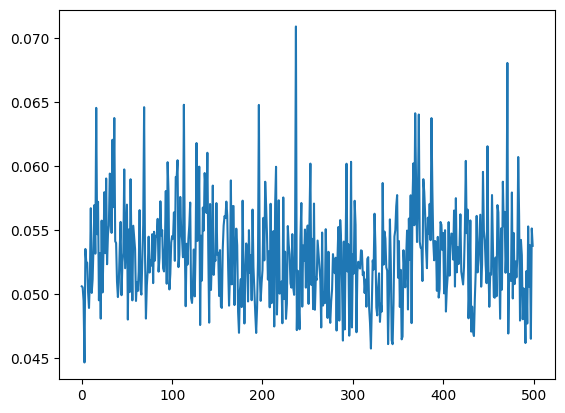

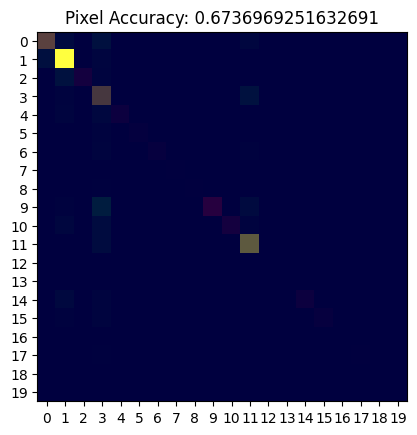

In [52]:
# These seeds are used for reproducibility
SEED = 1969
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.empty_cache()

# The number of epochs should be low at first, but can be increased once the best optimizer and learning rate are determined
epochs = 1

# The batch size could be adjusted based on the available memory, but we have determined that 4 is necessary given the A100 GPUs available
batch_size = 4

# Play with the optimizer and learning rate
opt = torch.optim.SGD
opt = torch.optim.Adam
opt = torch.optim.RAdam
opt = torch.optim.AdamW
opt = torch.optim.Adagrad
#lr = .1
lr = .01
#lr = .001
#lr = .0001

AE_trainer = SegmentationTrainer(AutoEncoder, batch_size, opt, lr)
AE_loss_history = AE_trainer.train(epochs)
plt.plot(list(range(len(AE_loss_history))), AE_loss_history)
AE_trainer.test(ema = False)

In [50]:
torch.cuda.empty_cache()

epochs = 1
opt = torch.optim.SGD
#opt = torch.optim.Adam
#opt = torch.optim.RAdam
#opt = torch.optim.AdamW
#opt = torch.optim.Adagrad
batch_size = 4
#lr = .1
lr = .01
#lr = .001
#lr = .0001


U_trainer = SegmentationTrainer(UNET, batch_size, opt, lr)
U_loss_history = U_trainer.train(epochs)
plt.plot(list(range(len(U_loss_history))), U_loss_history)
U_trainer.test(ema = False)

ValueError: optimizer got an empty parameter list

## Task 3: Compare the Results

The final Task is quite straightforwad, and it can possibly be done simultaneously with Task 2.

All we ask is that you use the functions provided to visualize examples of segmentation masks from the test set as output by the models side by side with the ground truth masks.

Bare in mind that downsampling the GTAV dataset and minimizing the number of classes (due to limited time and resources) makes even the ground truth masks quite ugly.

In [ ]:
# The datasets cannot be loaded in Dataloaders if we want to index them for visualization
train, test = GTAVSegmentationDataset(train=True), GTAVSegmentationDataset(train=False)

In [ ]:
idx = 25 # this is the free variable to test different images, let us know if you find any really interesting ones

test.plot_masked_im(idx)
test.plot_pred_masked_im(idx, AE_trainer.model)
test.plot_pred_masked_im(idx, U_trainer.model)